In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf # ticker data 
import datetime as dt
from numpy import nan
from time import sleep
import concurrent.futures
from functools import reduce
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import scipy 
import time
from datetime import datetime, timedelta
import requests

from dateutil.relativedelta import relativedelta
#Will Version monthly 1

In [2]:
#give 10 stocks

tickers = ['AAPL', 'AMZN', 'BAC', 'C', 'IBM', 'GOOG', 'MSFT', 'JPM', 'V', 'WFC']

START_DATE = '2010-12-31'
years=4


# Convert start_date string to datetime object
start_date_dt = datetime.strptime(START_DATE, '%Y-%m-%d')

# Add 6 years to start_date
end_date_dt = start_date_dt + relativedelta(years=years)

# Convert end_date_dt back to string format
END_DATE = end_date_dt.strftime('%Y-%m-%d')

print("End Date is:",END_DATE)




End Date is: 2014-12-31


In [3]:

# Convert START_DATE to a datetime object
start_date_obj = datetime.strptime(START_DATE, '%Y-%m-%d')

# Calculate the previous month's date
previous_month_start_date = (start_date_obj - relativedelta(months=12)).strftime('%Y-%m-%d')#get correlation from past year
#print(previous_month_start_date)


#initial DF
asset_df = yf.download(tickers[0], start=previous_month_start_date, end=END_DATE, progress=False)
asset_df


y = asset_df['Adj Close'].resample('M') \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.strftime('%Y-%m')
y.name = tickers[0]
df = pd.DataFrame(y)
#df.reset_index(inplace=True)

for x in range(1,10):
    asset_df = yf.download(tickers[x], start=previous_month_start_date, end=END_DATE, progress=False)
    y = asset_df['Adj Close'].resample('M') \
                             .last() \
                             .pct_change() \
                             .dropna()
    y.index = y.index.strftime('%Y-%m')
    y.name = tickers[x]
    ydf = pd.DataFrame(y)
    df = pd.concat([df, ydf], axis=1)

df.reset_index(drop=True, inplace=True)
PastReturns_df=df


In [4]:

PastReturns_df.head()

,AAPL,AMZN,BAC,C,IBM,GOOG,MSFT,JPM,V,WFC
0,-0.088596,-0.067722,0.007968,0.003022,-0.065012,-0.145230,-0.075459,-0.064392,-0.062085,0.053353
1,0.065396,-0.055897,0.097497,0.024097,0.043621,-0.005925,0.022146,0.077812,0.041183,-0.036667
2,0.148470,0.146706,0.072079,0.191176,0.008571,0.076538,0.021625,0.066238,0.067424,0.138259
3,0.111022,0.009796,-0.001120,0.079012,0.005848,-0.073036,0.042677,-0.047428,-0.008788,0.063946
4,-0.016125,-0.084902,-0.117218,-0.093822,-0.024015,-0.076222,-0.151394,-0.070456,-0.195747,-0.132177


In [5]:

 # Create a date range from START_DATE to END_DATE with a monthly frequency
date_range = pd.date_range(start=START_DATE, end=END_DATE, freq='M')

    # Create an empty DataFrame with the date_range as the index
date_range_df = pd.DataFrame(index=date_range)
date_range_df

    # Specify the stocks
stocks = tickers



    # Create columns for each stock and initialize them with NaN values
for stock in stocks:
    date_range_df[stock] = pd.Series(dtype=float)

date_range_df.head()

,AAPL,AMZN,BAC,C,IBM,GOOG,MSFT,JPM,V,WFC
2010-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Connected Graph Found


<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


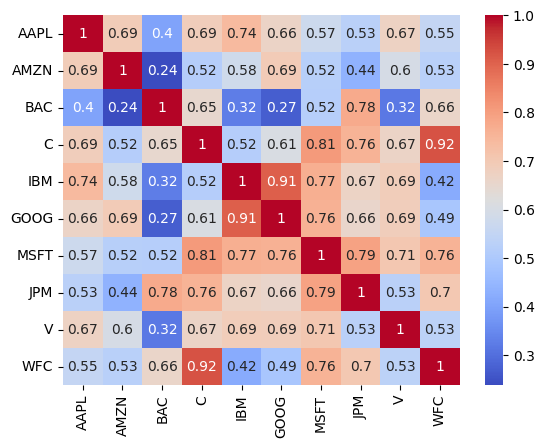

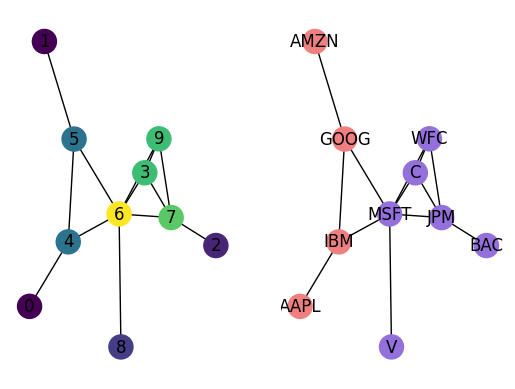

Connected Graph Found


<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


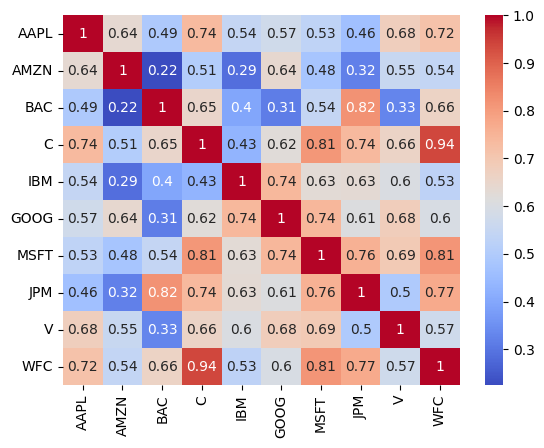

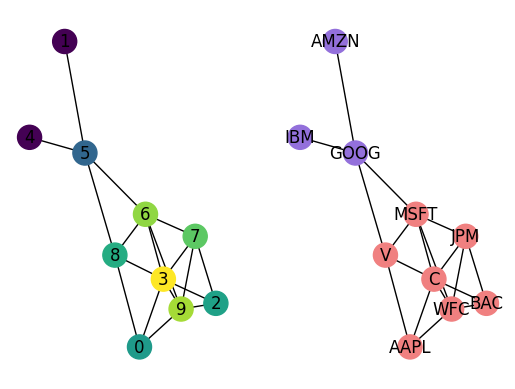

Connected Graph Found


<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


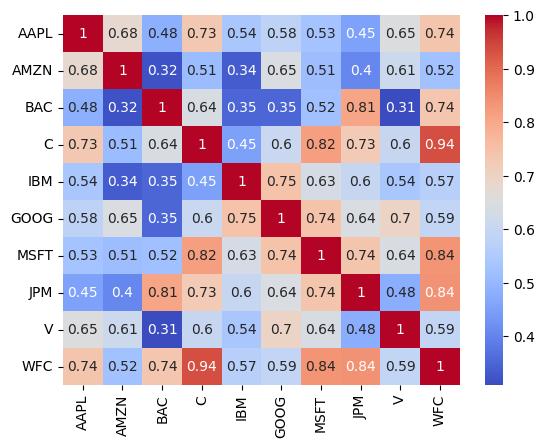

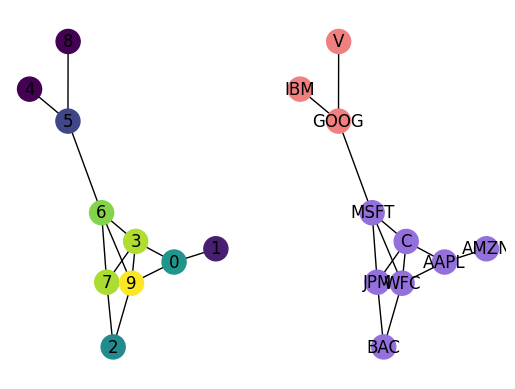

KeyboardInterrupt: 

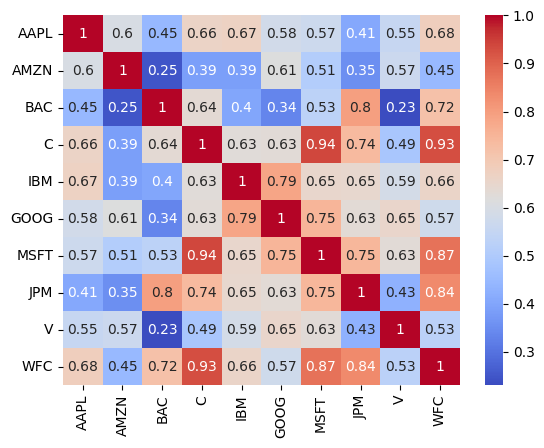

In [7]:
for x in range (years*12+1): 
    Last_12_months = PastReturns_df.iloc[x:12+x] #get the past 12 months data 
    returns_pct=Last_12_months
    corr = returns_pct.corr() # calculate the correlations between the returns of each pair of stocks
    sns.heatmap(corr,annot=True,cmap="coolwarm")   
    corr_df = pd.DataFrame(corr)
    titles = corr_df.columns.tolist()
    
    def truncate(f,relaxer=.99): 
        if (abs(f) < relaxer):
            return 0
        else:
            return 1
    relaxer=.9999
    truncated=corr.applymap(truncate)
    # we already know that every stock is perfectly correlated with itself, so the ones on the diagonal are not really useful information. Let's get rid of them.
    adj = truncated- np.identity(10)
    stocknet = nx.from_numpy_array(adj.to_numpy()) # initialize a new graph from our adjacency matrix

    while nx.is_connected(stocknet)==False:
        relaxer=relaxer-.0001
        truncated=corr.applymap(truncate)
        adj = corr.applymap(lambda x: truncate(x, relaxer=relaxer))- np.identity(10)
        stocknet = nx.from_numpy_array(adj.to_numpy()) # initialize a new graph from our adjacency matrix
    else:
        print("Connected Graph Found")
        #print(relaxer)

    IndexedStocknet=stocknet
    Indexedstock_layout = nx.spring_layout(IndexedStocknet,seed=10)
    stocknet = nx.relabel_nodes(stocknet, dict(enumerate(adj.columns))) # keep the stock tickers as the names of the nodes (instead of integers)
    stock_layout = nx.spring_layout(stocknet,seed=10) # fix our layout
    L = nx.laplacian_matrix(stocknet).todense()
    (u,v) = np.linalg.eig(L)
    u_sorted = np.sort(u)
    v_sorted = v[:, u.argsort()]
    colors = [ "lightcoral" for i in range(0,10) ]
    for i in range(0,10):
        if (v_sorted[i,1] < 0):
            colors[i] = "mediumpurple"


    eigen_cent = nx.eigenvector_centrality(IndexedStocknet)
    eigen_colors = [eigen_cent[i] for i in range(0,10)]
    fig, (ax1, ax2) = plt.subplots(ncols=2)

    # Draw the graphs in the subplots
    nx.draw(IndexedStocknet,Indexedstock_layout,node_color=eigen_colors,with_labels=True,ax=ax1)
    nx.draw(stocknet,stock_layout,node_color=colors,with_labels=True,ax=ax2)

    plt.show()
    
    df = pd.DataFrame(eigen_cent,index=[0])
    dfT= pd.DataFrame(titles)
    # print the resulting DataFrame
    mat1=df.T
    mat2=dfT
    Centrality_results = mat1.values.flatten().tolist()
    date_range_df.loc[date_range[x]] = Centrality_results

    


In [77]:


date_range_df.head()


,AAPL,AMZN,BAC,C,IBM,GOOG,MSFT,JPM,V,WFC
2010-12-31,0.074512,0.074512,0.124845,0.402242,0.256828,0.256828,0.553891,0.430317,0.160697,0.402242
2011-01-31,0.278295,0.042542,0.291477,0.477671,0.042542,0.184578,0.405522,0.367434,0.310239,0.419561
2011-02-28,0.280821,0.076559,0.258654,0.449043,0.036453,0.133707,0.417529,0.444295,0.036453,0.504453
2011-03-31,0.220692,0.060826,0.220692,0.426623,0.392197,0.329111,0.378162,0.392197,0.130717,0.375285
2011-04-30,0.262629,0.056972,0.159528,0.409629,0.325355,0.401451,0.426106,0.308505,0.092435,0.426885


In [76]:

file_path = 'CentralityData1.xlsx'
date_range_df.to_excel(file_path, index=True)

